In [9]:
# from colorizers import *
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from models import *
from tqdm.notebook import tqdm
from skimage.color import rgb2lab, lab2rgb
import torch_dct as dct

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'model_fft.pt'

In [11]:
dataset_name = 'imagewang'
train_dataset = torchvision.datasets.ImageFolder(
    root=f"./{dataset_name}/train",
    transform=transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()]),
)
valid_dataset = torchvision.datasets.ImageFolder(
    root=f"./{dataset_name}/val",
    transform=transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()]),
)
with open('map_clsloc.txt', 'r') as f:
    class2idx = f.read().strip().split('\n')
    class2idx = [line.split() for line in class2idx]
    class2idx = {id:int(target) for id, target, _ in class2idx}


In [12]:
subset_idx_to_idx = {}
for class_name in train_dataset.class_to_idx:
    subset_idx_to_idx[train_dataset.class_to_idx[class_name]] = class2idx[class_name]

In [16]:
def train(model, classifier, dataset, batch_size = 12, epochs = 10, lr = 0.005, save_every = 100):
    train_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers=3)
    # writer = SummaryWriter()
    grey_scale = transforms.Grayscale()
    crit = nn.MSELoss()
    classifier_crit = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    steps = 0
    for e in range(epochs):
        total_loss = 0.0
        for image, target in tqdm(train_dataloader):
            steps += 1
            image = image.to(DEVICE)
            image_bw = grey_scale(image)
            optim.zero_grad()
            output = model(image_bw)
            # loss = crit(output.view(-1, 224*224*3), image.view(-1, 224*224*3))
            dct_output = dct.dct_2d(output).contiguous()
            with torch.no_grad():
                dct_target = dct.dct_2d(image).contiguous()
            loss = crit(dct_output.view(-1, 224*224*3), dct_target.view(-1, 224*224*3))
            if classifier:
                target = torch.tensor([subset_idx_to_idx[x.item()] for x in target])
                target = target.to(DEVICE)
                classifier_output = classifier(output)
                loss += 0.002 * classifier_crit(classifier_output, target)
            loss.backward()
            optim.step()
            total_loss += loss.item()
            # writer.add_scalar('Loss/train', loss.item(), steps)
            if steps % save_every == 0:
                torch.save(model.state_dict(), model_name)
                
        print(total_loss / len(train_dataloader))

In [17]:
model = Colorizer().to(DEVICE)
model.load_state_dict(torch.load(model_name))
# pretrained_classifier = torchvision.models.resnet18(pretrained=True).to(DEVICE)
# for param in pretrained_classifier.parameters():
#     param.requires_grad = False

<All keys matched successfully>

In [40]:
train(model, None, train_dataset, batch_size = 8, epochs = 50, lr=0.0001)

  0%|          | 0/1834 [00:00<?, ?it/s]

3710.757391177711


  0%|          | 0/1834 [00:00<?, ?it/s]

In [ ]:
def valid(model, dataset, valid_num=3, save_name='model'):
    valid_dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=3)
    grey_scale = transforms.Grayscale()
    with torch.no_grad():
        plt.figure(figsize=(10, 4*valid_num))
        plt.tight_layout()
        # plt.axis(False)
        plt.subplots_adjust(hspace=0.2)
        for index, (image, _target) in enumerate(valid_dataloader):
            if index >= valid_num:
                break
            image = image.to(DEVICE)
            image_bw = grey_scale(image)
            result = model(image_bw).squeeze().cpu().numpy().transpose(1, 2, 0)
            numpy_image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
            lab_result = rgb2lab(result)
            lab_image = rgb2lab(numpy_image)
            lab_result[:, :, 0] = lab_image[:, :, 0]
            final_result = lab2rgb(lab_result)
            plt.subplot(valid_num, 3, 1 + index * 3)
            plt.imshow(image_bw.squeeze().cpu().numpy(), cmap='gray')
            plt.subplot(valid_num, 3, 2 + index * 3)
            plt.imshow(numpy_image)
            plt.subplot(valid_num, 3, 3 + index * 3)
            plt.imshow(final_result)
            plt.savefig(f"{save_name}_result.jpg")


In [ ]:
model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

/home/bill/Source/colorization/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:338: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


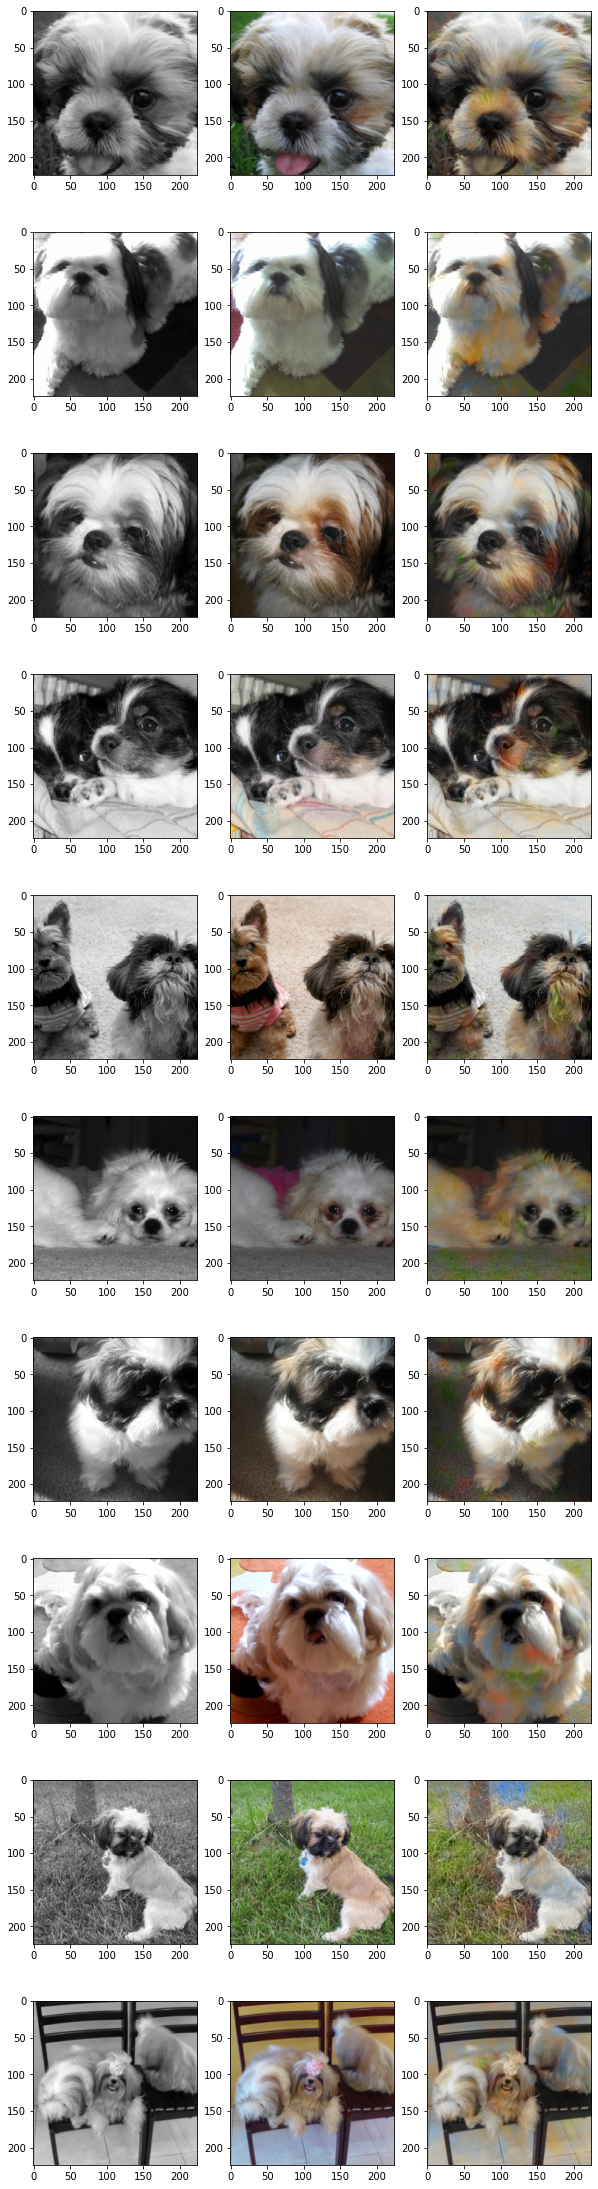

In [ ]:
valid(model, valid_dataset, 10, "dct_loss")